In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import argparse
import torch.utils.data
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
train_data=datasets.MNIST(
    root='MNIST',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
test_data=datasets.MNIST(
    root='MNIST',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)


In [3]:
from torch.utils.data import DataLoader

In [4]:
train_loader=DataLoader(dataset=train_data,batch_size=128,shuffle=True)
test_loader=DataLoader(dataset=test_data,batch_size=128,shuffle=True)

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE()

In [6]:
log_interval=10
lr = 0.0003

def loss_function( recon_x, x, mu, logvar):
    BCE_loss = nn.BCELoss(reduction='sum')
    recons_loss = BCE_loss(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1+logvar-torch.exp(logvar)-mu**2)
    loss = recons_loss + kl_divergence 
    return loss

optimizer = torch.optim.Adam(model.parameters(), lr)

In [7]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = torch.flatten(data, start_dim=1)
            
        data = Variable(data)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()/ len(data)))
            

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


In [8]:
def test(epoch):
    model.eval()
    test_loss = 0
    for data, _ in test_loader:
        data = torch.flatten(data, start_dim=1)
        
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [9]:
for epoch in range(10):
    train(epoch)
    test(epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 548.889160
Train Epoch: 0 [1280/60000 (2%)]	Loss: 466.806915
Train Epoch: 0 [2560/60000 (4%)]	Loss: 361.093750
Train Epoch: 0 [3840/60000 (6%)]	Loss: 293.470215
Train Epoch: 0 [5120/60000 (9%)]	Loss: 256.145142
Train Epoch: 0 [6400/60000 (11%)]	Loss: 238.923828
Train Epoch: 0 [7680/60000 (13%)]	Loss: 235.860703
Train Epoch: 0 [8960/60000 (15%)]	Loss: 233.691681
Train Epoch: 0 [10240/60000 (17%)]	Loss: 236.310303
Train Epoch: 0 [11520/60000 (19%)]	Loss: 231.445648
Train Epoch: 0 [12800/60000 (21%)]	Loss: 221.303177
Train Epoch: 0 [14080/60000 (23%)]	Loss: 219.223694
Train Epoch: 0 [15360/60000 (26%)]	Loss: 216.245224
Train Epoch: 0 [16640/60000 (28%)]	Loss: 205.966980
Train Epoch: 0 [17920/60000 (30%)]	Loss: 206.913483
Train Epoch: 0 [19200/60000 (32%)]	Loss: 211.495255
Train Epoch: 0 [20480/60000 (34%)]	Loss: 199.888565
Train Epoch: 0 [21760/60000 (36%)]	Loss: 195.794067
Train Epoch: 0 [23040/60000 (38%)]	Loss: 199.079987
Train Epoch: 0 [24320/60000 

<ipython-input-8-c368228bbad6>:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True)


====> Test set loss: 154.6693
Train Epoch: 1 [0/60000 (0%)]	Loss: 157.716293
Train Epoch: 1 [1280/60000 (2%)]	Loss: 156.487701
Train Epoch: 1 [2560/60000 (4%)]	Loss: 160.533600
Train Epoch: 1 [3840/60000 (6%)]	Loss: 164.060211
Train Epoch: 1 [5120/60000 (9%)]	Loss: 156.554596
Train Epoch: 1 [6400/60000 (11%)]	Loss: 150.802704
Train Epoch: 1 [7680/60000 (13%)]	Loss: 149.396088
Train Epoch: 1 [8960/60000 (15%)]	Loss: 150.752487
Train Epoch: 1 [10240/60000 (17%)]	Loss: 146.883621
Train Epoch: 1 [11520/60000 (19%)]	Loss: 144.355469
Train Epoch: 1 [12800/60000 (21%)]	Loss: 150.497803
Train Epoch: 1 [14080/60000 (23%)]	Loss: 146.782623
Train Epoch: 1 [15360/60000 (26%)]	Loss: 140.202332
Train Epoch: 1 [16640/60000 (28%)]	Loss: 146.642456
Train Epoch: 1 [17920/60000 (30%)]	Loss: 145.798431
Train Epoch: 1 [19200/60000 (32%)]	Loss: 145.885056
Train Epoch: 1 [20480/60000 (34%)]	Loss: 141.894577
Train Epoch: 1 [21760/60000 (36%)]	Loss: 141.118561
Train Epoch: 1 [23040/60000 (38%)]	Loss: 146.10963

Train Epoch: 4 [17920/60000 (30%)]	Loss: 117.075920
Train Epoch: 4 [19200/60000 (32%)]	Loss: 117.063034
Train Epoch: 4 [20480/60000 (34%)]	Loss: 117.963631
Train Epoch: 4 [21760/60000 (36%)]	Loss: 122.868309
Train Epoch: 4 [23040/60000 (38%)]	Loss: 123.192337
Train Epoch: 4 [24320/60000 (41%)]	Loss: 119.089592
Train Epoch: 4 [25600/60000 (43%)]	Loss: 116.607407
Train Epoch: 4 [26880/60000 (45%)]	Loss: 116.499794
Train Epoch: 4 [28160/60000 (47%)]	Loss: 117.926315
Train Epoch: 4 [29440/60000 (49%)]	Loss: 118.875320
Train Epoch: 4 [30720/60000 (51%)]	Loss: 120.005066
Train Epoch: 4 [32000/60000 (53%)]	Loss: 118.329575
Train Epoch: 4 [33280/60000 (55%)]	Loss: 121.617249
Train Epoch: 4 [34560/60000 (58%)]	Loss: 118.667526
Train Epoch: 4 [35840/60000 (60%)]	Loss: 119.236191
Train Epoch: 4 [37120/60000 (62%)]	Loss: 117.416412
Train Epoch: 4 [38400/60000 (64%)]	Loss: 114.339119
Train Epoch: 4 [39680/60000 (66%)]	Loss: 117.826111
Train Epoch: 4 [40960/60000 (68%)]	Loss: 115.816513
Train Epoch:

Train Epoch: 7 [35840/60000 (60%)]	Loss: 114.744705
Train Epoch: 7 [37120/60000 (62%)]	Loss: 112.980202
Train Epoch: 7 [38400/60000 (64%)]	Loss: 113.669182
Train Epoch: 7 [39680/60000 (66%)]	Loss: 111.897369
Train Epoch: 7 [40960/60000 (68%)]	Loss: 110.721916
Train Epoch: 7 [42240/60000 (70%)]	Loss: 110.537750
Train Epoch: 7 [43520/60000 (72%)]	Loss: 111.947540
Train Epoch: 7 [44800/60000 (75%)]	Loss: 111.885551
Train Epoch: 7 [46080/60000 (77%)]	Loss: 113.495819
Train Epoch: 7 [47360/60000 (79%)]	Loss: 110.686371
Train Epoch: 7 [48640/60000 (81%)]	Loss: 115.843956
Train Epoch: 7 [49920/60000 (83%)]	Loss: 111.107895
Train Epoch: 7 [51200/60000 (85%)]	Loss: 110.353729
Train Epoch: 7 [52480/60000 (87%)]	Loss: 112.808914
Train Epoch: 7 [53760/60000 (90%)]	Loss: 112.257065
Train Epoch: 7 [55040/60000 (92%)]	Loss: 111.378174
Train Epoch: 7 [56320/60000 (94%)]	Loss: 109.719948
Train Epoch: 7 [57600/60000 (96%)]	Loss: 108.320663
Train Epoch: 7 [58880/60000 (98%)]	Loss: 109.574356
====> Epoch:

In [10]:
import matplotlib.pyplot as plt
import numpy as np

torch.Size([28, 28])


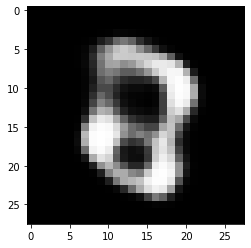

In [13]:
data = torch.randn(1,20)
y=model.decode(data)
img=y.reshape(28,28)
img = img.cpu().detach()
print(img.shape)
img = img.numpy()
plt.imshow(img,cmap ='gray')
plt.show()